In [1]:
import os
import time
import random
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from dataset_path import output_path
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import optimizers, metrics
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import os
from sklearn import metrics
from thesis_helper import *

pd.set_option('float_format', '{:.3f}'.format)
path = output_path

output_path = os.path.join(path, "Figure3")
if not os.path.exists(output_path):
    os.makedirs(output_path)
df_train = pd.read_csv((os.path.join(path, 'train.csv')))
df_test = pd.read_csv((os.path.join(path, 'test.csv')))
confidence_interval = 95
random_seed = 0
result_list = []

In [2]:
X_train,y_train,X_test,y_test = preprocessing(path,df_train,df_test)

Before filtering: training size = 334480 , testing size = 83620
After filtering: training size = 176213 , testing size = 44063


In [7]:
df_train = df_train[(df_train['outcome_hospitalization'] == False)]
df_test = df_test[(df_test['outcome_hospitalization'] == False)].reset_index()
outcome = "outcome_ed_revisit_3d"
variable = ["age", "gender", 
            
            "n_ed_30d", "n_ed_90d", "n_ed_365d", "n_hosp_30d", "n_hosp_90d", 
            "n_hosp_365d", "n_icu_30d", "n_icu_90d", "n_icu_365d", 
            
            "triage_pain", "triage_acuity",
            
            "chiefcom_chest_pain", "chiefcom_abdominal_pain", "chiefcom_headache", 
            "chiefcom_shortness_of_breath", "chiefcom_back_pain", "chiefcom_cough", 
            "chiefcom_nausea_vomiting", "chiefcom_fever_chills", "chiefcom_syncope",
            "chiefcom_dizziness",
            
            "cci_MI", "cci_CHF", "cci_PVD", "cci_Stroke", "cci_Dementia", "cci_Pulmonary", 
            "cci_Rheumatic", "cci_PUD", "cci_Liver1", "cci_DM1", "cci_DM2", 
            "cci_Paralysis", "cci_Renal", "cci_Cancer1", "cci_Liver2", "cci_Cancer2", 
            "cci_HIV",
            
            "eci_Arrhythmia", "eci_Valvular", "eci_PHTN",  "eci_HTN1", "eci_HTN2",  
            "eci_NeuroOther", "eci_Hypothyroid", "eci_Lymphoma", "eci_Coagulopathy", 
            "eci_Obesity", "eci_WeightLoss", "eci_FluidsLytes", "eci_BloodLoss", 
            "eci_Anemia", "eci_Alcohol", "eci_Drugs", "eci_Psychoses", "eci_Depression",
            
            "ed_temperature_last", "ed_heartrate_last", "ed_resprate_last", 
            "ed_o2sat_last", "ed_sbp_last", "ed_dbp_last", "ed_los", "n_med", "n_medrecon"]


X_train = df_train[variable].copy()
y_train = df_train[outcome].copy()

X_test = df_test[variable].copy()
y_test = df_test[outcome].copy()

resample_freq = '1H' #'30T'
df_vitalsign = pd.read_csv(os.path.join(path, 'ed_vitalsign_' + resample_freq + '_resampled.csv'))
encoder = LabelEncoder()
X_train['gender'] = encoder.fit_transform(X_train['gender'])
X_test['gender'] = encoder.transform(X_test['gender'])
X_train['ed_los'] = pd.to_timedelta(X_train['ed_los']).dt.seconds / 60
X_test['ed_los'] = pd.to_timedelta(X_test['ed_los']).dt.seconds / 60


,index,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,...,ed_pain_last,n_med,n_medrecon,triage_MAP,score_CCI,score_CART,score_REMS,score_NEWS,score_NEWS2,score_MEWS
0,183244,14328106,NaN,32336955,2159-11-08 15:13:00,2159-11-09 01:47:00,F,WHITE,WALK IN,HOME,...,0.000,5.000,9.000,84.333,3,9,8,1,1,1
1,376935,18860711,NaN,35614382,2159-10-24 06:19:00,2159-10-24 14:31:00,F,WHITE,WALK IN,HOME,...,4.000,1.000,5.000,65.000,0,4,2,1,1,1
2,291579,16860825,NaN,37485359,2203-01-07 17:45:00,2203-01-08 07:00:00,F,BLACK/AFRICAN AMERICAN,AMBULANCE,HOME,...,3.000,0.000,14.000,106.667,7,4,3,1,1,1
4,69316,11648387,NaN,39707189,2181-01-23 09:25:00,2181-01-23 13:27:00,M,WHITE,WALK IN,HOME,...,0.000,0.000,16.000,116.000,9,13,9,2,2,3
5,317924,17474234,NaN,39613641,2161-01-14 02:12:00,2161-01-14 04:57:00,F,OTHER,AMBULANCE,HOME,...,0.000,1.000,1.000,90.000,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334468,401602,19450132,NaN,37807611,2177-09-27 11:13:00,2177-09-27 15:07:00,M,BLACK/AFRICAN AMERICAN,WALK IN,HOME,...,2.000,0.000,5.000,126.667,2,0,4,0,0,1
334471,185338,14372392,NaN,30202625,2121-06-15 14:55:00,2121-06-16 04:49:00,M,WHITE,WALK IN,HOME,...,8.000,4.000,1.000,98.000,1,4,3,0,0,1
334475,200654,14730006,NaN,30085487,2200-02-25 14:42:00,2200-02-25 18:21:00,F,BLACK/AFRICAN AMERICAN,WALK IN,HOME,...,0.000,0.000,5.000,97.000,1,0,2,0,0,1
334476,237191,15574665,NaN,31650665,2196-12-23 17:22:00,2196-12-24 07:49:00,F,WHITE,WALK IN,HOME,...,0.000,0.000,12.000,68.667,2,8,9,1,1,1


In [9]:
def get_score_performance(s, random_seed=0):
    print(s)
    score = np.array(df_test[s])
    result = PlotROCCurve(score,y_test, ci=confidence_interval, random_seed=random_seed)
    runtime = 0
    results = [s]
    results.extend(result)
    results.append(runtime)
    result_list.append(results)


score_NEWS
AUC: 0.542298560069473
AUPRC: 0.055394376722718644
Sensitivity: 0.5237873134328358
Specificity: 0.5482239557241346
Score thresold: 1
2.5 97.5


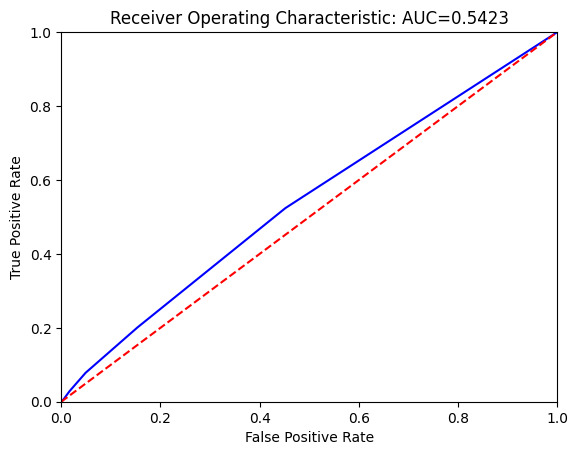

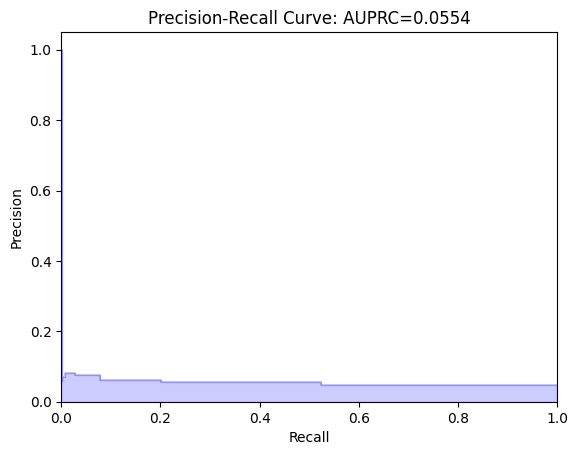

In [12]:
# get_score_performance("score_NEWS", random_seed=random_seed)
f, accuracy1, sensitivity1, specificity1 = find_sens_speci(gb,X_test,y_test)

In [4]:
X_train.describe()
ros = RandomOverSampler(sampling_strategy='minority',random_state=8) # 6:6961
X_ros, y_ros = ros.fit_resample(X_train,y_train)

In [16]:
x_ros= X_ros[['ed_los','age','ed_sbp_last','ed_heartrate_last','ed_dbp_last', 'ed_temperature_last', 'n_medrecon', 'triage_pain', 'n_med', 'ed_o2sat_last']].describe().round(3).to_csv("my_description_after.csv")

Training time: 126.21733736991882 seconds
AUC: 0.7029582616332208
AUPRC: 0.16602832946995844
Sensitivity: 0.6007462686567164
Specificity: 0.7014003196641141
Score thresold: 0.47309092377306855
2.5 97.5


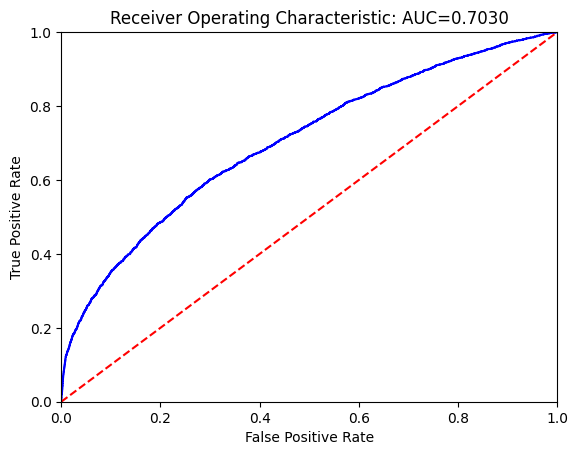

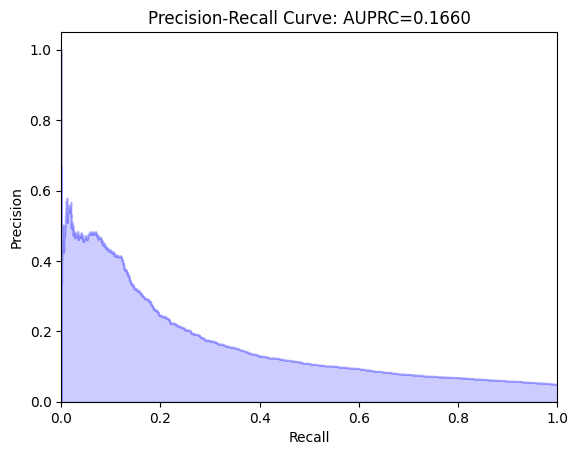

In [4]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=random_seed)
start = time.time()
gb.fit(X_ros,y_ros)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
probs = gb.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

results = ["GB"]
results.extend(result)
results.append(runtime)
result_list.append(results)


In [5]:
f, accuracy1, sensitivity1, specificity1 = find_sens_speci(gb,X_test,y_test)

In [6]:
print(f, accuracy1, sensitivity1, specificity1)

0.17057985147400795 0.7490638404103216 0.7602519144063551 0.5303171641791045


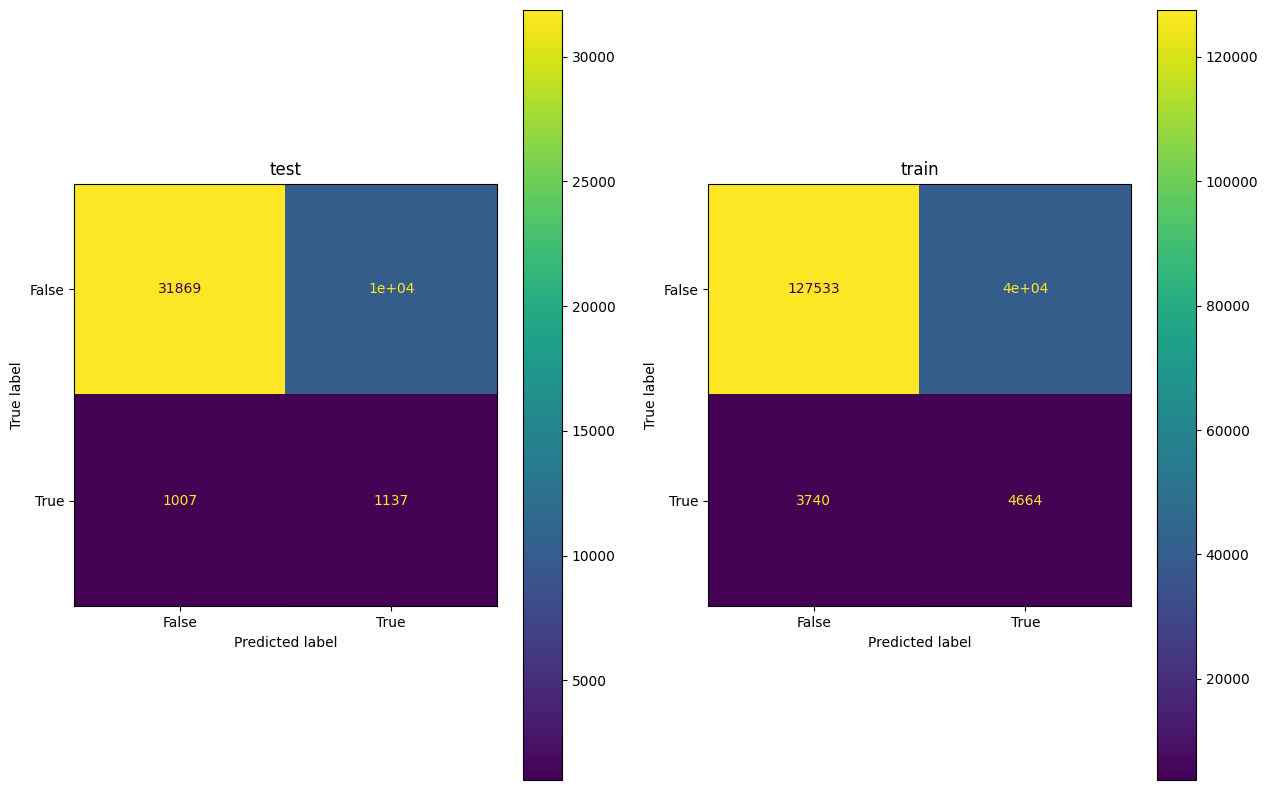

In [7]:
CM_plot_train_test(gb,X_train,y_train,X_test,y_test)

Learning rate set to 0.123444
0:	learn: 0.6784171	total: 53ms	remaining: 53s
1:	learn: 0.6671899	total: 105ms	remaining: 52.2s
2:	learn: 0.6583133	total: 152ms	remaining: 50.5s
3:	learn: 0.6517372	total: 194ms	remaining: 48.2s
4:	learn: 0.6462799	total: 243ms	remaining: 48.4s
5:	learn: 0.6420973	total: 298ms	remaining: 49.3s
6:	learn: 0.6385237	total: 348ms	remaining: 49.4s
7:	learn: 0.6359114	total: 388ms	remaining: 48.1s
8:	learn: 0.6330629	total: 434ms	remaining: 47.8s
9:	learn: 0.6310031	total: 478ms	remaining: 47.3s
10:	learn: 0.6293608	total: 517ms	remaining: 46.5s
11:	learn: 0.6278067	total: 562ms	remaining: 46.3s
12:	learn: 0.6266095	total: 618ms	remaining: 46.9s
13:	learn: 0.6255511	total: 665ms	remaining: 46.8s
14:	learn: 0.6245982	total: 745ms	remaining: 48.9s
15:	learn: 0.6237498	total: 787ms	remaining: 48.4s
16:	learn: 0.6226565	total: 839ms	remaining: 48.5s
17:	learn: 0.6217053	total: 890ms	remaining: 48.6s
18:	learn: 0.6209985	total: 938ms	remaining: 48.4s
19:	learn: 0.6

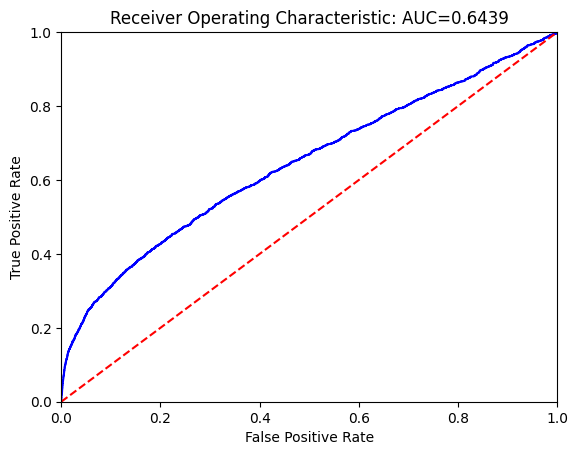

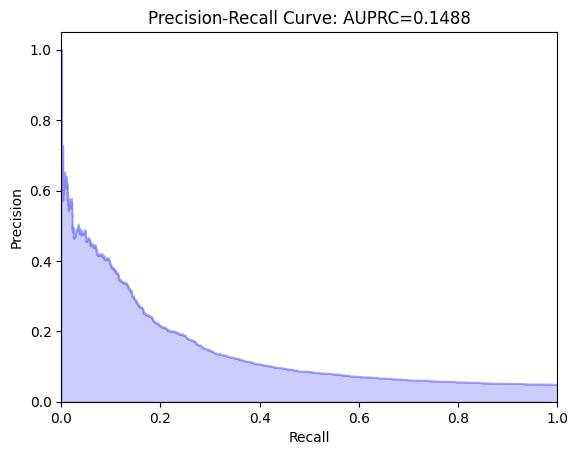

In [9]:
from sklearn.svm import SVC
from catboost import CatBoostRegressor,CatBoostClassifier

cat_model = CatBoostClassifier()
# Fit model
start = time.time()
cat_model.fit(X_ros,y_ros)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
import pickle
with open('task3_logreg.pickle', 'wb') as model_dump:
    pickle.dump(cat_model, model_dump)
probs = cat_model.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["CatBoost"]
results.extend(result)
results.append(runtime)
result_list.append(results)
# CM_plot_train_test(cat_model,X_train,y_train,X_test,y_test)

In [10]:

yp = cat_model.predict(X_test)
arr = []
for x in yp:
    if x == 'True':
        arr.append(True)
    else:
        arr.append(False)
y_t = y_test.to_numpy()
cm1 = confusion_matrix(y_t,arr)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])

f = f1_score(y_t,arr)

print(f, accuracy1, sensitivity1, specificity1)
# f, accuracy1, sensitivity1, specificity1 = find_sens_speci(cat_model,X_test,y_test)

0.1764109496451504 0.8340784785420875 0.8580595911162003 0.365205223880597


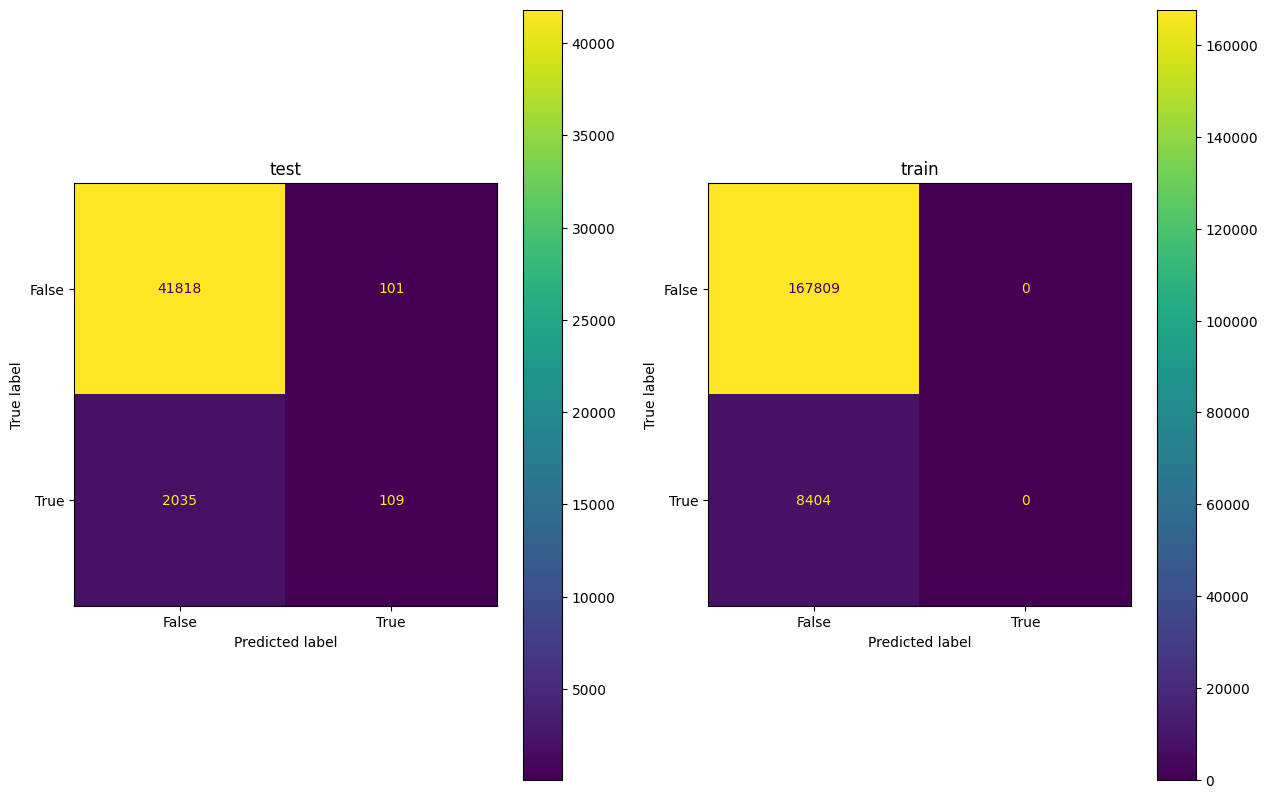

In [61]:
new_probs_train = cat_model.predict(X_train)
new_probs_train
    # cm1 = metrics.confusion_matrix(y_train,new_probs_train)
    # train_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = [False, True])
    # train_cm_display.plot()
new_probs_train = np.array(new_probs_train, dtype=bool)
new_probs_test = cat_model.predict(X_test)
new_probs_test = np.array(new_probs_test, dtype=bool)
# cm1 = metrics.confusion_matrix(y_test,new_probs_test)
# train_cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = [False, True])
# train_cm_display.plot()
arr_train = []
for x in new_probs_train:
    if x == 'True':
        arr_train.append(True)
    else:
        arr_train.append(False)

y_train11 = y_train.to_numpy()
fig, ax = plt.pyplot.subplots(1, 2,figsize=(15,10))
ax[0].set_title("test")
ax[1].set_title("train")

metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(y_t, arr), 
    display_labels=[False, True]).plot(ax=ax[0])

metrics.ConfusionMatrixDisplay(
    confusion_matrix=metrics.confusion_matrix(y_train11, arr_train), 
    display_labels=[False, True]).plot(ax=ax[1])

In [ ]:
import lightgbm as lgb
from sklearn.svm import SVC
from catboost import CatBoostRegressor,CatBoostClassifier

lgb_model = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=45)
# Fit model
start = time.time()
lgb_model.fit(X_ros,y_ros)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
import pickle
with open('task3_logreg.pickle', 'wb') as model_dump:
    pickle.dump(cat_model, model_dump)
probs = lgb_model.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["LightGbm"]
results.extend(result)
results.append(runtime)
result_list.append(results)
CM_plot_train_test(lgb_model,X_train,y_train,X_test,y_test)

Training time: 2.4385416507720947 seconds
AUC: 0.6965363059817209
AUPRC: 0.16919550976257444
Sensitivity: 0.6072761194029851
Specificity: 0.6839380710417711
Score thresold: 0.45773290909752923
2.5 97.5


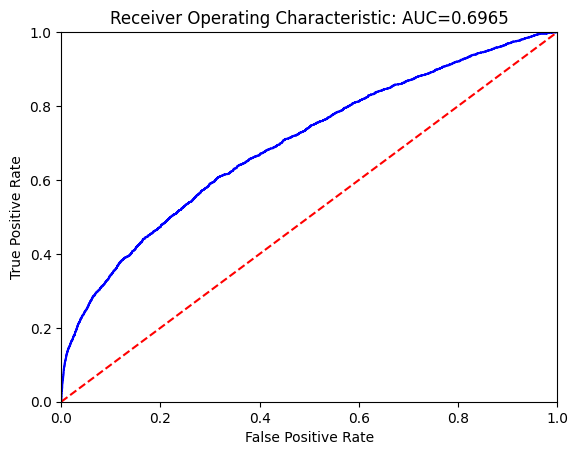

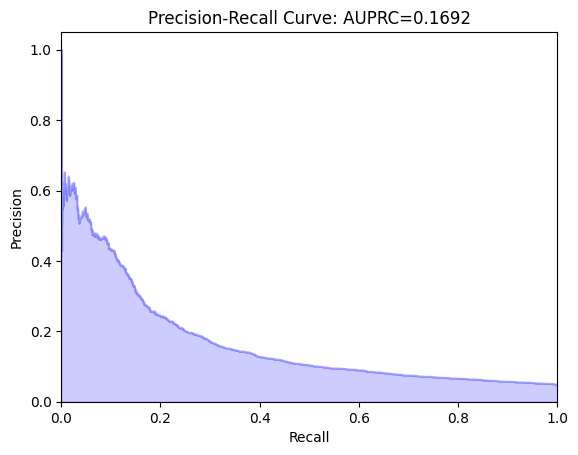

ValueError: feature_names mismatch: ['age', 'gender', 'n_ed_30d', 'n_ed_90d', 'n_ed_365d', 'n_hosp_30d', 'n_hosp_90d', 'n_hosp_365d', 'triage_pain', 'chiefcom_chest_pain', 'chiefcom_abdominal_pain', 'chiefcom_headache', 'chiefcom_shortness_of_breath', 'chiefcom_back_pain', 'chiefcom_cough', 'chiefcom_nausea_vomiting', 'chiefcom_fever_chills', 'chiefcom_syncope', 'chiefcom_dizziness', 'cci_Pulmonary', 'cci_Liver1', 'cci_DM1', 'eci_Arrhythmia', 'eci_HTN2', 'eci_FluidsLytes', 'eci_Alcohol', 'eci_Drugs', 'eci_Depression', 'ed_heartrate_last', 'ed_o2sat_last', 'ed_los', 'n_med', 'n_medrecon'] ['age', 'gender', 'n_ed_30d', 'n_ed_90d', 'n_ed_365d', 'n_hosp_30d', 'n_hosp_90d', 'n_hosp_365d', 'n_icu_30d', 'n_icu_90d', 'n_icu_365d', 'triage_pain', 'triage_acuity', 'chiefcom_chest_pain', 'chiefcom_abdominal_pain', 'chiefcom_headache', 'chiefcom_shortness_of_breath', 'chiefcom_back_pain', 'chiefcom_cough', 'chiefcom_nausea_vomiting', 'chiefcom_fever_chills', 'chiefcom_syncope', 'chiefcom_dizziness', 'cci_MI', 'cci_CHF', 'cci_PVD', 'cci_Stroke', 'cci_Dementia', 'cci_Pulmonary', 'cci_Rheumatic', 'cci_PUD', 'cci_Liver1', 'cci_DM1', 'cci_DM2', 'cci_Paralysis', 'cci_Renal', 'cci_Cancer1', 'cci_Liver2', 'cci_Cancer2', 'cci_HIV', 'eci_Arrhythmia', 'eci_Valvular', 'eci_PHTN', 'eci_HTN1', 'eci_HTN2', 'eci_NeuroOther', 'eci_Hypothyroid', 'eci_Lymphoma', 'eci_Coagulopathy', 'eci_Obesity', 'eci_WeightLoss', 'eci_FluidsLytes', 'eci_BloodLoss', 'eci_Anemia', 'eci_Alcohol', 'eci_Drugs', 'eci_Psychoses', 'eci_Depression', 'ed_temperature_last', 'ed_heartrate_last', 'ed_resprate_last', 'ed_o2sat_last', 'ed_sbp_last', 'ed_dbp_last', 'ed_los', 'n_med', 'n_medrecon']
training data did not have the following fields: cci_PUD, n_icu_90d, cci_Dementia, cci_Cancer1, ed_temperature_last, eci_Lymphoma, eci_Coagulopathy, eci_Hypothyroid, eci_Anemia, eci_WeightLoss, eci_PHTN, cci_MI, cci_CHF, cci_Liver2, eci_BloodLoss, cci_PVD, ed_sbp_last, triage_acuity, n_icu_30d, cci_Renal, cci_DM2, cci_Stroke, cci_Rheumatic, cci_Cancer2, cci_Paralysis, eci_Obesity, ed_dbp_last, cci_HIV, eci_NeuroOther, eci_Valvular, eci_Psychoses, eci_HTN1, ed_resprate_last, n_icu_365d

In [27]:
import lightgbm as lgb
from sklearn.svm import SVC
from catboost import CatBoostRegressor,CatBoostClassifier
from xgboost import XGBClassifier
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree',colsample_bylevel=1,
       colsample_bynode=1,colsample_bytree=1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=3, min_child_weight=1,n_estimators=250, n_jobs=20, nthread=None,
        random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
# Fit model
start = time.time()
xgb_model.fit(X_ros,y_ros)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
import pickle
with open('task3_logreg.pickle', 'wb') as model_dump:
    pickle.dump(cat_model, model_dump)
probs = lgb_model.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["LightGbm"]
results.extend(result)
results.append(runtime)
result_list.append(results)
CM_plot_train_test(xgb_model,X_train,y_train,X_test,y_test)

In [36]:
xgb_model = XGBClassifier(base_score=0.5, booster='gbtree',colsample_bylevel=1,
       colsample_bynode=1,colsample_bytree=1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=3, min_child_weight=1,n_estimators=250, n_jobs=20, nthread=None,
        random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)
xgb_model.fit(X_ros,y_ros)
find_sens_speci(xgb_model,X_test,y_test)



(0.17173193813957066,
 0.7556907155663481,
 0.7677186955795702,
 0.5205223880597015)

[LightGBM] [Info] Number of positive: 167809, number of negative: 167809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1431
[LightGBM] [Info] Number of data points in the train set: 335618, number of used features: 67
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0:	learn: 0.6503182	total: 179ms	remaining: 10.6s
1:	learn: 0.6421160	total: 208ms	remaining: 6.02s
2:	learn: 0.6384222	total: 241ms	remaining: 4.58s
3:	learn: 0.6353635	total: 270ms	remaining: 3.79s
4:	learn: 0.6330204	total: 298ms	remaining: 3.28s
5:	learn: 0.6314180	total: 327ms	remaining: 2.95s
6:	learn: 0.6303428	total: 356ms	remaining: 2.7s
7:	learn: 0.6295747	total: 388ms	remaining: 2.52s
8:	learn: 0.6284823	total: 419ms	remaining: 2.37s
9:	learn: 0.6279080	total: 449ms	remaining: 2

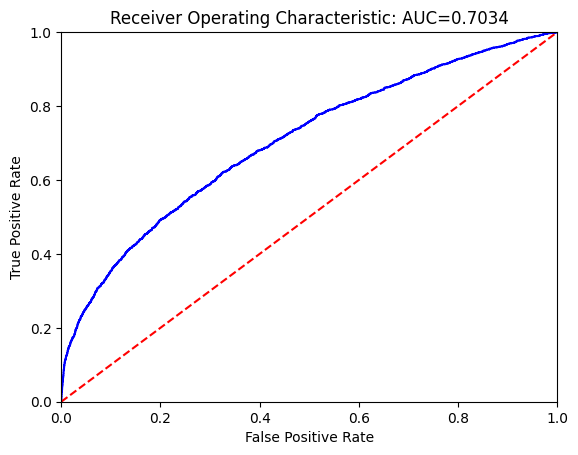

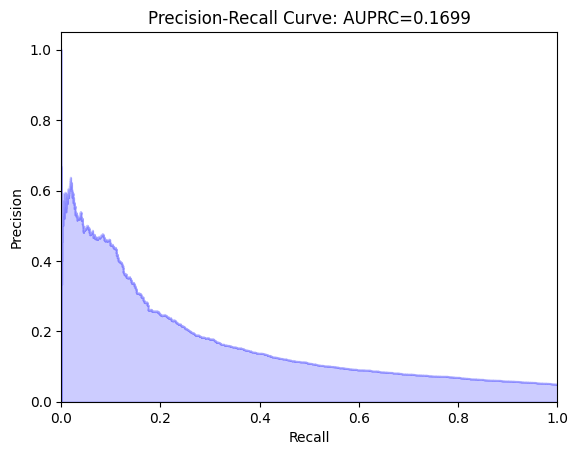

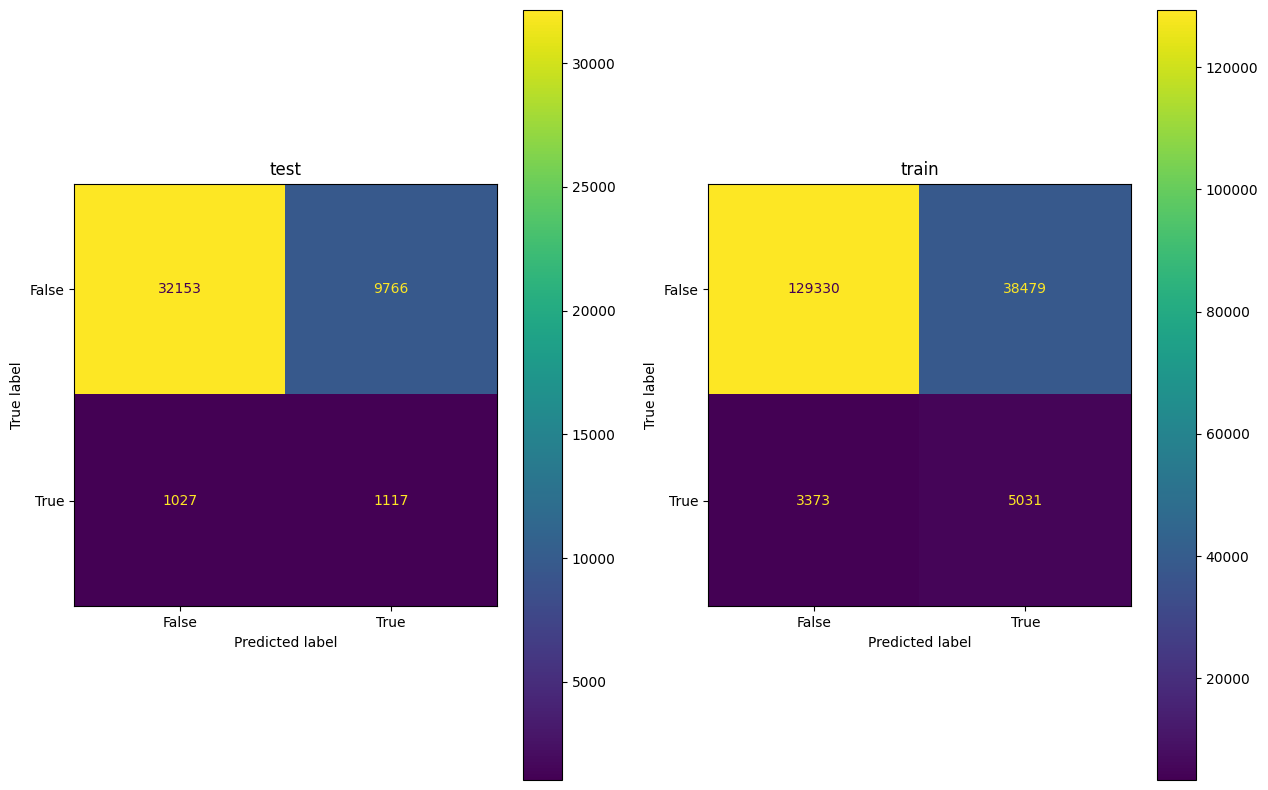

In [5]:
import lightgbm as lgb
import imblearn
from imblearn.pipeline import Pipeline
from catboost import CatBoostRegressor,CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import NearMiss

from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
start = time.time()
clf1 = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=45)
clf2 = CatBoostClassifier(iterations=60,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass',random_state=45)
clf3 = XGBClassifier(base_score=0.5, booster='gbtree',colsample_bylevel=1,
       colsample_bynode=1,colsample_bytree=1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=3, min_child_weight=1,n_estimators=250, n_jobs=20, nthread=None,
        random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


eclf = VotingClassifier(estimators=[('LGB', clf1), ('CatB', clf2), ('XGB', clf3)],voting='soft',weights = [1,1,1])
eclf.fit(X_ros,y_ros)
runtime = time.time()-start
probs = eclf.predict_proba(X_test)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["Ensemble classfier"]
results.extend(result)
results.append(runtime)
result_list.append(results)
CM_plot_train_test(eclf,X_train,y_train,X_test,y_test)

In [22]:
find_sens_speci(eclf,X_test,y_test)

(0.1714899823443617,
 0.7550552617842634,
 0.7670268851833297,
 0.5209888059701493)

In [88]:
from sklearn.metrics import confusion_matrix
yp = eclf.predict(X_test)
cm1 = confusion_matrix(y_test,yp)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[41849    70]
 [ 2066    78]]
Accuracy :  0.9515239543381068
Sensitivity :  0.9983301128366612
Specificity :  0.036380597014925374


In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from feature_engine.selection import SelectBySingleFeaturePerformance
from catboost import CatBoostRegressor,CatBoostClassifier
import lightgbm as lgb
sel = SelectBySingleFeaturePerformance(
    estimator=CatBoostClassifier(iterations=60,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass',random_state=45),
    scoring='roc_auc',
    cv=3,
    threshold=None,
)

X_train_t = sel.fit_transform(X_train, y_train)
X_test_t = sel.transform(X_test)

0:	learn: 0.2379867	total: 151ms	remaining: 8.92s
1:	learn: 0.1957981	total: 163ms	remaining: 4.72s
2:	learn: 0.1913968	total: 173ms	remaining: 3.29s
3:	learn: 0.1908999	total: 183ms	remaining: 2.56s
4:	learn: 0.1908570	total: 193ms	remaining: 2.13s
5:	learn: 0.1907990	total: 203ms	remaining: 1.82s
6:	learn: 0.1907882	total: 212ms	remaining: 1.6s
7:	learn: 0.1907662	total: 221ms	remaining: 1.44s
8:	learn: 0.1907513	total: 231ms	remaining: 1.31s
9:	learn: 0.1906947	total: 241ms	remaining: 1.21s
10:	learn: 0.1906834	total: 251ms	remaining: 1.12s
11:	learn: 0.1906639	total: 260ms	remaining: 1.04s
12:	learn: 0.1906388	total: 270ms	remaining: 976ms
13:	learn: 0.1906330	total: 279ms	remaining: 915ms
14:	learn: 0.1906262	total: 288ms	remaining: 863ms
15:	learn: 0.1906224	total: 296ms	remaining: 813ms
16:	learn: 0.1906202	total: 305ms	remaining: 772ms
17:	learn: 0.1906118	total: 314ms	remaining: 733ms
18:	learn: 0.1906066	total: 323ms	remaining: 697ms
19:	learn: 0.1905901	total: 331ms	remainin

AttributeError: module 'matplotlib' has no attribute 'ylabel'

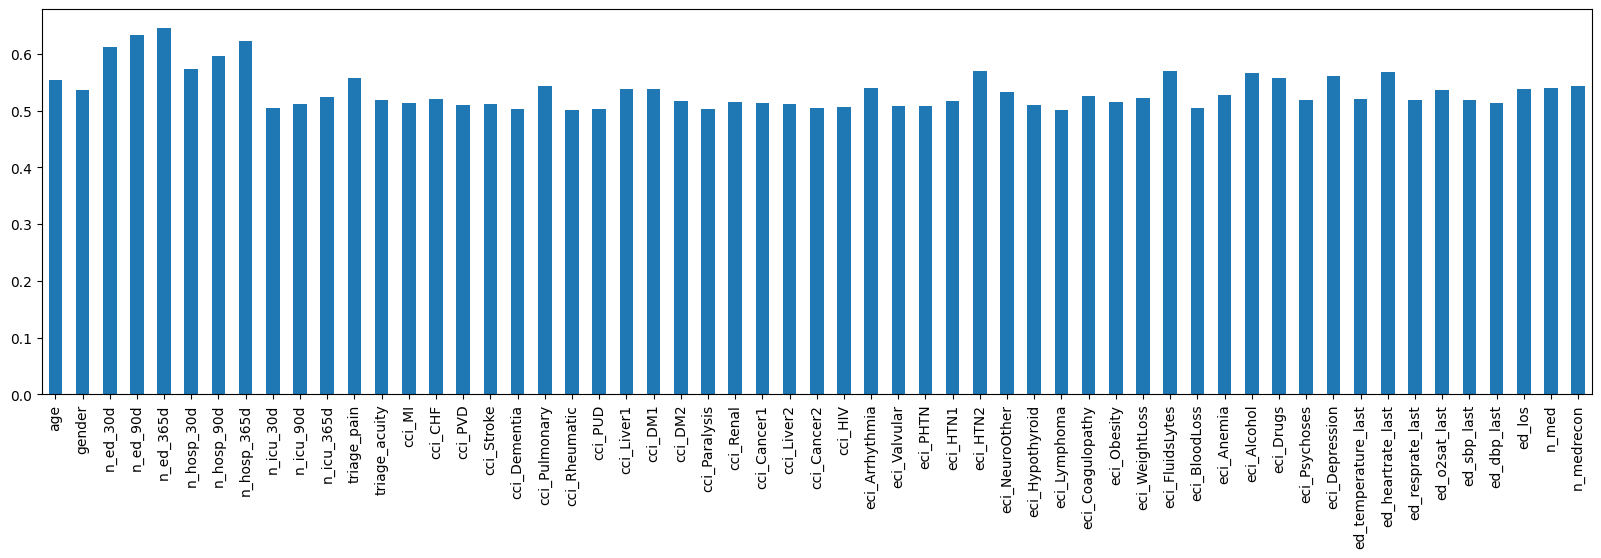

In [23]:
pd.Series(sel.feature_performance_).plot.bar(figsize=(20,5))
plt.ylabel('roc-auc')
plt.show()

[LightGBM] [Info] Number of positive: 167809, number of negative: 167809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.058694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 335618, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0:	learn: 0.6481029	total: 25.8ms	remaining: 1.52s
1:	learn: 0.6396163	total: 44.9ms	remaining: 1.3s
2:	learn: 0.6361084	total: 67.8ms	remaining: 1.29s
3:	learn: 0.6344335	total: 90.1ms	remaining: 1.26s
4:	learn: 0.6326050	total: 109ms	remaining: 1.2s
5:	learn: 0.6307414	total: 128ms	remaining: 1.15s
6:	learn: 0.6297749	total: 149ms	remaining: 1.13s
7:	learn: 0.6286643	total: 168ms	remaining: 1.09s
8:	learn: 0.6280883	total: 191ms	remaining: 1.08s
9:	learn: 0.6273329	total: 214ms	remaining:

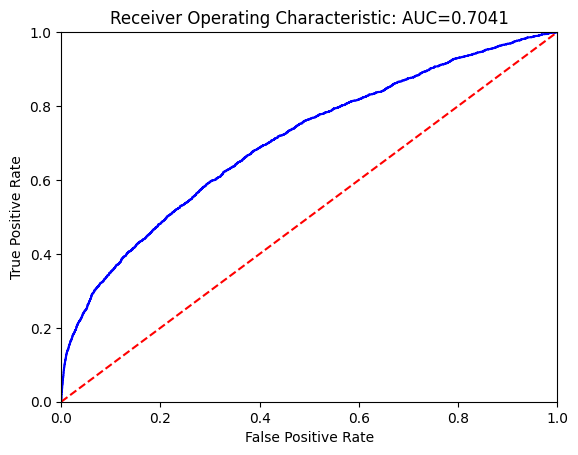

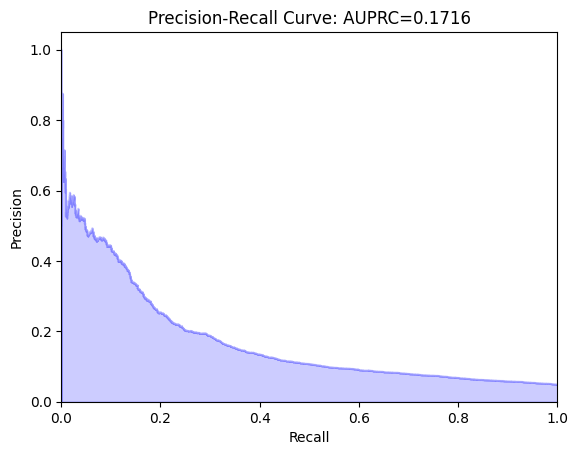

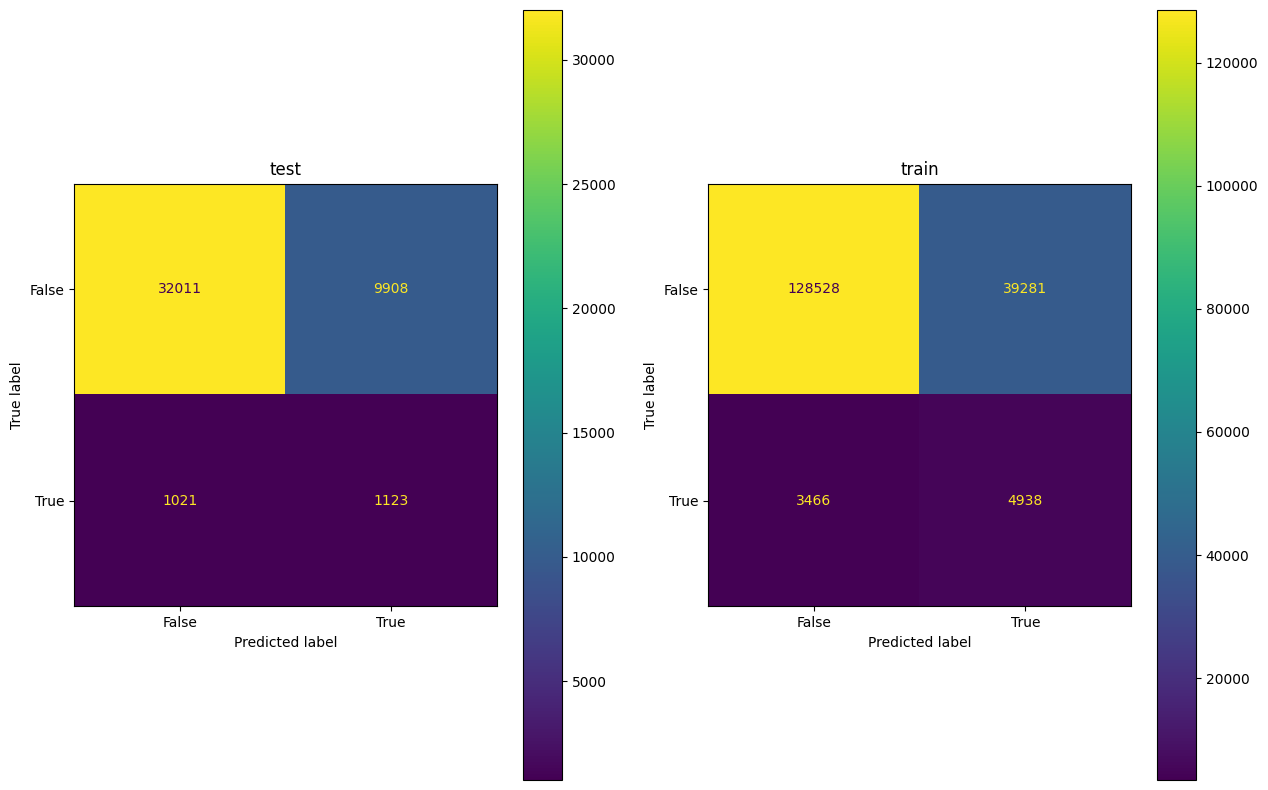

In [24]:
import lightgbm as lgb
import imblearn
from imblearn.pipeline import Pipeline
from catboost import CatBoostRegressor,CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import NearMiss

from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NeighbourhoodCleaningRule
# X_ros, y_ros = X_new,y_train
ros = RandomOverSampler(sampling_strategy='minority',random_state=8) # 6:6961
X_ros, y_ros = ros.fit_resample(X_train_t,y_train)
clf1 = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=45)
clf2 = CatBoostClassifier(iterations=60,
                           learning_rate=1,
                           depth=2,
                           loss_function='MultiClass',random_state=45)
clf3 = XGBClassifier(base_score=0.5, booster='gbtree',colsample_bylevel=1,
       colsample_bynode=1,colsample_bytree=1, gamma=0, learning_rate=0.2,
       max_delta_step=0, max_depth=3, min_child_weight=1,n_estimators=250, n_jobs=20, nthread=None,
        random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)


eclf = VotingClassifier(estimators=[('LGB', clf1), ('CatB', clf2), ('XGB', clf3)],voting='soft',weights = [1,1,1])
eclf.fit(X_ros,y_ros)
probs = eclf.predict_proba(X_test_t)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
# results = ["Ensemble classfier"]
# results.extend(result)
# results.append(runtime)
# result_list.append(results)
CM_plot_train_test(eclf,X_train_t,y_train,X_test_t,y_test)

In [26]:
find_sens_speci(eclf,X_test_t,y_test)

(0.1704743833017078,
 0.7519687719855661,
 0.7636393997948424,
 0.5237873134328358)

In [91]:
from sklearn.metrics import confusion_matrix
yp = eclf.predict(X_test_t)
cm1 = confusion_matrix(y_test,yp)
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))
#####from confusion matrix calculate accuracy
accuracy1=(cm1[0,0]+cm1[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[32011  9908]
 [ 1021  1123]]
Accuracy :  0.7519687719855661
Sensitivity :  0.7636393997948424
Specificity :  0.5237873134328358


In [81]:
result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task3.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,GB,0.040,0.701 (0.692-0.711),0.171 (0.164-0.186),0.634 (0.603-0.648),0.654 (0.649-0.684),37.790
1,CatBoost,0.040,0.7 (0.691-0.711),0.168 (0.16-0.184),0.633 (0.597-0.652),0.661 (0.636-0.706),35.740
2,LightGbm,0.042,0.703 (0.693-0.714),0.171 (0.162-0.186),0.615 (0.606-0.668),0.678 (0.627-0.698),0.741
3,Ensemble classfier,0.042,0.705 (0.696-0.717),0.172 (0.163-0.187),0.621 (0.607-0.652),0.673 (0.631-0.693),0.741


In [126]:
from sklearn.model_selection import cross_val_score, GridSearchCV
params = {'voting':['soft'],
          'weights':[(1,1,1),(1,3,1),(2,4,1),(2,5,1),(1,6,1),(1,2,1),(1,1,3)]}

#fit gridsearch & print best params
grid = GridSearchCV(eclf, params,cv=5,scoring='roc_auc')
grid.fit(X_ros,y_ros)
print('\n')
print(f'The best params is : {grid.best_params_}')

[LightGBM] [Info] Number of positive: 134247, number of negative: 134247
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 883
[LightGBM] [Info] Number of data points in the train set: 268494, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
0:	learn: 0.6478838	total: 19.5ms	remaining: 1.15s
1:	learn: 0.6395245	total: 37.4ms	remaining: 1.08s
2:	learn: 0.6359824	total: 57.2ms	remaining: 1.09s
3:	learn: 0.6341644	total: 73.5ms	remaining: 1.03s
4:	learn: 0.6318712	total: 89.9ms	remaining: 989ms
5:	learn: 0.6308647	total: 106ms	remaining: 956ms
6:	learn: 0.6301579	total: 124ms	remaining: 939ms
7:	learn: 0.6292027	total: 142ms	remaining: 925ms
8:	learn: 0.6281409	total: 165ms	remaining: 933ms
9:	learn: 0.6274865	total: 179ms	remaini

In [129]:
tuned_eclf = VotingClassifier(estimators=[('NB', clf1), ('CB', clf2), ('LR', clf3)],**grid.best_params_, n_jobs = -1)
tuned_cvm = cross_val_score(tuned_eclf, X_ros,y_ros)
tuned_score = tuned_cvm.mean()
tuned_std = tuned_cvm.std()
print('\n')
print(f'The average tuned cross-validation score is {round(tuned_score, 4)} (+- {round(tuned_std, 4)})')




The average tuned cross-validation score is 0.6749 (+- 0.0013)


In [130]:
grid.best_params_

{'voting': 'soft', 'weights': (1, 1, 1)}

AUC: 0.7040917331506071
AUPRC: 0.17155667105588487
Sensitivity: 0.6226679104477612
Specificity: 0.6717478947493977
Score thresold: 0.45876710435393514
2.5 97.5


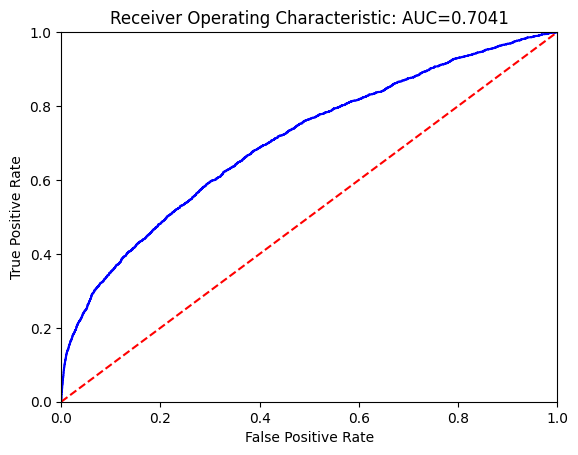

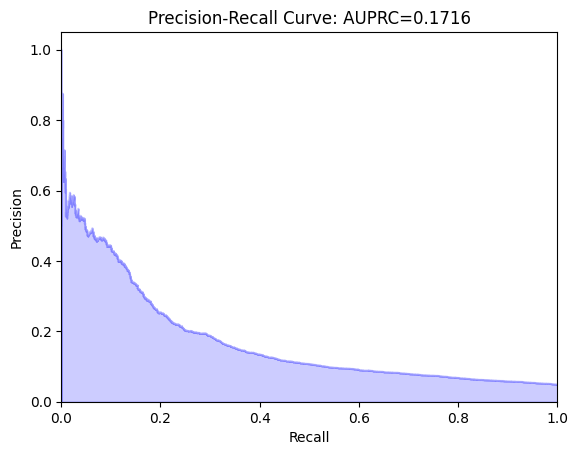

In [131]:
tuned_eclf.fit(X_ros,y_ros)
probs = tuned_eclf.predict_proba(X_test_t)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)

[LightGBM] [Info] Number of positive: 167809, number of negative: 167809
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 886
[LightGBM] [Info] Number of data points in the train set: 335618, number of used features: 33
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
2.5 97.5
0:	learn: 0.6481029	total: 23.3ms	remaining: 1.38s
1:	learn: 0.6396163	total: 46.8ms	remaining: 1.36s
2:	learn: 0.6361084	total: 67.2ms	remaining: 1.28s
3:	learn: 0.6344335	total: 88.8ms	remaining: 1.24s
4:	learn: 0.6326050	total: 110ms	remaining: 1.21s
5:	learn: 0.6307414	total: 135ms	remaining: 1.22s
6:	learn: 0.6297749	total: 161ms	remaining: 1.22s
7:	learn: 0.6286643	total: 186ms	remaining: 1.21s
8:	learn: 0.6280883	total: 215ms	remaining: 1.22s
9:	learn: 0.6273329	total: 241ms

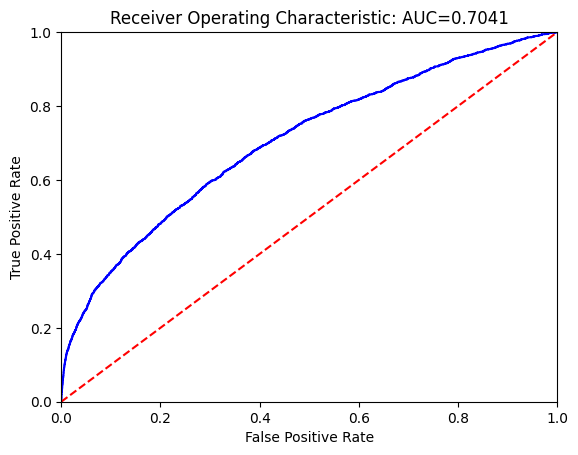

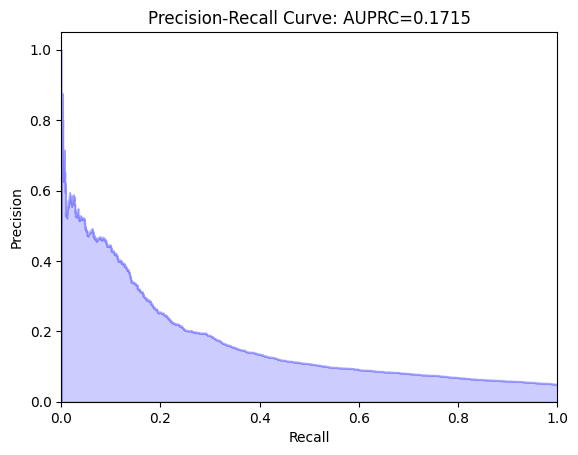

In [90]:
from sklearn.metrics import auc
def get_models():
    models = list()
    models.append(('knn', clf1))
    models.append(('cart', clf2))
    models.append(('svm', clf3))
    return models

# evaluate each base model
def evaluate_models(models, X_train, X_val, y_train, y_val):
    # fit and evaluate the models
    scores = list()
    for name, model in models:
    # fit the model
        model.fit(X_train, y_train)
        # evaluate the model
        yhat = model.predict_proba(X_val)
        results = ROC_result(yhat[:,1],y_val, ci=confidence_interval, random_seed=random_seed)
        au = results[0]
        # store the performance
        scores.append(au)
    # report model performance
    return scores
models = get_models()
scores = evaluate_models(models, X_ros, X_test_t, y_ros, y_test)
tuned_eclf = VotingClassifier(estimators=[('NB', clf1), ('CB', clf2), ('LR', clf3)], voting='soft',weights = scores, n_jobs = -1)
# tuned_cvm = cross_val_score(tuned_eclf, X_ros,y_ros)
# tuned_score = tuned_cvm.mean()
# tuned_std = tuned_cvm.std()
# print('\n')
# print(f'The average tuned cross-validation score is {round(tuned_score, 4)} (+- {round(tuned_std, 4)})')
tuned_eclf.fit(X_ros,y_ros)
probs = tuned_eclf.predict_proba(X_test_t)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
# CM_plot_train_test(eclf,X_train,y_train,X_test,y_test)

In [91]:
print(scores)

[0.697206157940349, 0.7016736234913602, 0.698714447247766]


In [ ]:
# Lasso regularization
# recursive feature elmination

# X_ros,y_ros = X_train,y_train
# Random Oversampling
# SMOTE
# Borderline SMOTE
# SVM SMote
# k-Means SMOTE
# ADASYN

# Methods that Select Examples to Keep
# Near Miss Undersampling
# Condensed Nearest Neighbor Rule for Undersampling
# Methods that Select Examples to Delete
# Tomek Links for Undersampling
# Edited Nearest Neighbors Rule for Undersampling
# Combinations of Keep and Delete Methods
# One-Sided Selection for Undersampling
# Neighborhood Cleaning Rule for Undersampling

Dividing variable into groups

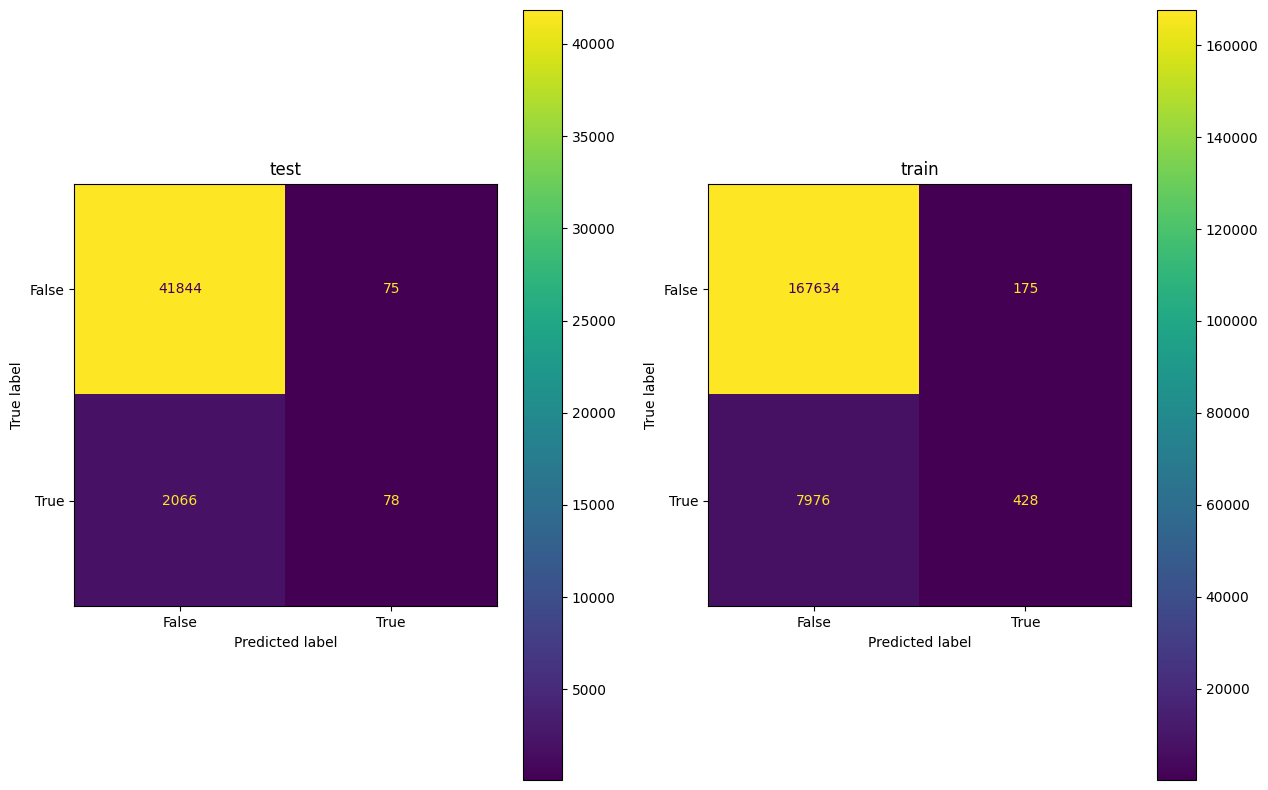

In [37]:
CM_plot_train_test(gb,X_train,y_train,X_test,y_test)

C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training time: 2.3515255451202393 seconds
AUC: 0.6907045299338845
AUPRC: 0.16656283575195688
Sensitivity: 0.6156716417910447
Specificity: 0.6484648965862736
Score thresold: 0.45766337328968343
2.5 97.5


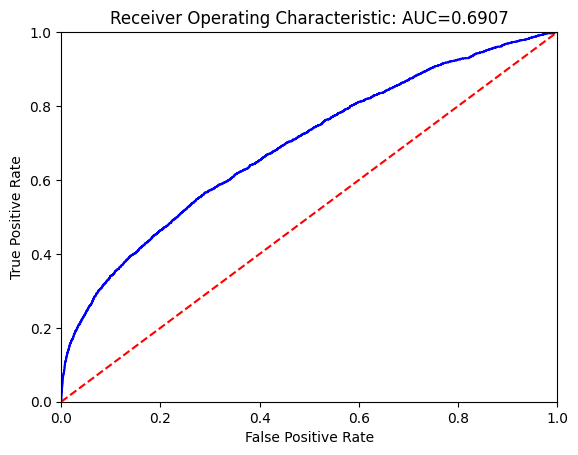

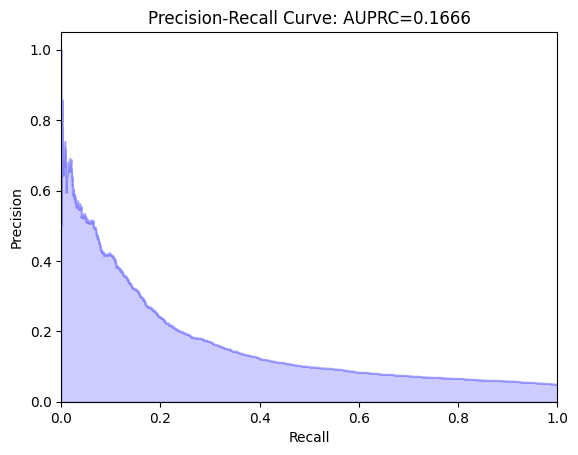

In [40]:
from sklearn.feature_selection import SelectFromModel
lo=LogisticRegression(random_state=1)
start = time.time()
lo.fit(X_ros,y_ros)
# model = SelectFromModel(lo, prefit=True)
runtime = time.time()-start
print('Training time:', runtime, 'seconds')
import pickle
with open('task3_logreg.pickle', 'wb') as model_dump:
    pickle.dump(lo, model_dump)
probs = lo.predict_proba(X_test_t)
result = PlotROCCurve(probs[:,1],y_test, ci=confidence_interval, random_seed=random_seed)
results = ["Logistic regression"]
results.extend(result)
results.append(runtime)
result_list.append(results)

CM for test

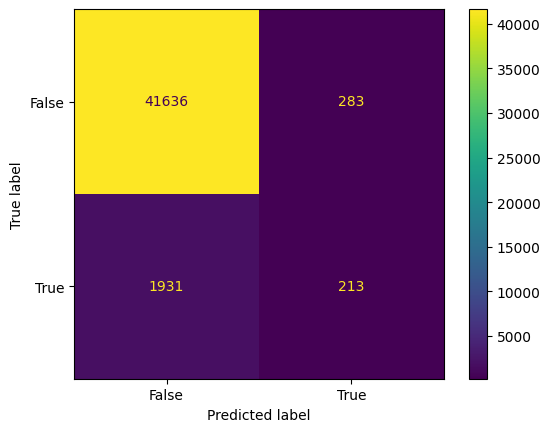

0.6618024192633275


In [ ]:
probs_em = eclf.predict(X_test)
cm1 = metrics.confusion_matrix(y_test,probs_em)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = [False, True])

cm_display.plot()
plt.savefig(path + '/confusion_matrix.png')
plt.show()
acc = metrics.accuracy_score(y_test, new_probs)
print(acc)

CM for train

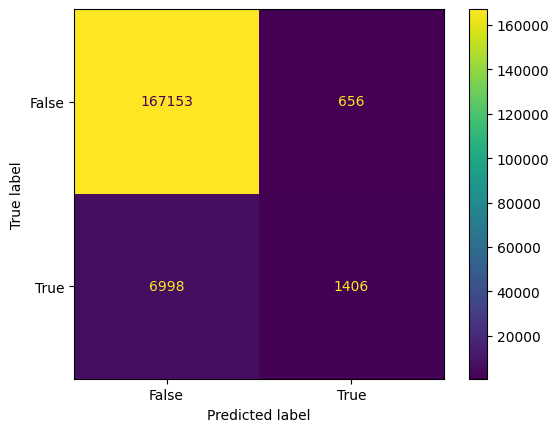

NameError: name 'new_probs' is not defined

In [10]:
probs_em = eclf.predict(X_train)
cm1 = metrics.confusion_matrix(y_train,probs_em)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm1, display_labels = [False, True])

cm_display.plot()
plt.savefig(path + '/confusion_matrix.png')
plt.show()
acc = metrics.accuracy_score(y_test, probs_em)
print(acc)

In [11]:

result_df = pd.DataFrame(result_list, columns=['Model', 'auroc', 'ap', 'sensitivity', 'specificity', 'threshold', 'lower_auroc', 'upper_auroc', 'std_auroc', 'lower_ap', 'upper_ap', 'std_ap', 'lower_sensitivity', 'upper_sensitivity', 'std_sensitivity', 'lower_specificity', 'upper_specificity', 'std_specificity', 'runtime'])
#result_df.to_csv(os.path.join(path, 'result_72h_ed_revivist_disposition.csv'), index=False)
result_df = result_df.round(3)
formatted_result_df = pd.DataFrame()
formatted_result_df[['Model', 'Threshold']] = result_df[['Model', 'threshold']]
formatted_result_df['AUROC'] = result_df['auroc'].astype(str) + ' (' + result_df['lower_auroc'].astype(str) + \
                               '-' + result_df['upper_auroc'].astype(str) + ')'
formatted_result_df['AUPRC'] = result_df['ap'].astype(str) + ' (' + result_df['lower_ap'].astype(str) + \
                               '-' + result_df['upper_ap'].astype(str) + ')'
formatted_result_df['Sensitivity'] = result_df['sensitivity'].astype(str) + ' (' + result_df['lower_sensitivity'].astype(str) + \
                                     '-' + result_df['upper_sensitivity'].astype(str) + ')'
formatted_result_df['Specificity'] = result_df['specificity'].astype(str) + ' (' + result_df['lower_specificity'].astype(str) + \
                                     '-' + result_df['upper_specificity'].astype(str) + ')'
formatted_result_df[['Runtime']] = result_df[['runtime']]
formatted_result_df.to_csv(os.path.join(path, 'task3.csv'), index=False)
formatted_result_df

,Model,Threshold,AUROC,AUPRC,Sensitivity,Specificity,Runtime
0,Logistic regression,0.044,0.682 (0.674-0.689),0.162 (0.151-0.175),0.599 (0.56-0.631),0.659 (0.629-0.702),3.063
1,CatBoost,0.040,0.7 (0.691-0.711),0.168 (0.16-0.184),0.633 (0.597-0.652),0.661 (0.636-0.706),37.521
2,GaussianNB,0.000,0.674 (0.667-0.685),0.103 (0.097-0.107),0.632 (0.586-0.652),0.621 (0.607-0.672),0.368
3,Ensemble Classfier,0.032,0.699 (0.691-0.708),0.168 (0.157-0.182),0.607 (0.599-0.645),0.693 (0.647-0.71),40.987


In [ ]:
t = 0
f = 0
for x in y_train:
    if x == True:
        t += 1
    else:
        f += 1
for x in y_test:
    if x == True:
        t += 1
    else:
        f += 1        
print(t)
print(f)